<a id='top'></a>

# Homework 5: Confidence intervals and other things
***

**Name**: **Theodore Margoles**

***

This assignment is due on Moodle by **5 PM on Friday November 9**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do Cell $\rightarrow$ Run All as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) | [Problem 4](#p4)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
import scipy.stats as stats
import datetime
from matplotlib import dates
%matplotlib inline

---

<a id='p1'></a>
[Back to top](#top)

### [30 points] Problem 1 - Sea-level rise, schmee-level rise!

You have been contacted by the local government of Key West, Florida, to assess whether there is statistical evidence for sea-level rise in the area. You obtain from the University of Hawaii Sea Level Center's [gigantic repository of sea-level data](https://uhslc.soest.hawaii.edu/data/?rq) the daily mean sea levels file [linked here](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm0rl5dp6y4) and below.

In this problem, you will:
1. practice calculating confidence intervals, 
1. practice wrangling a real-life data set into a form where you can actually compute these confidence intervals, because life will rarely be so kind as to simply hand you a nicely packaged and cleaned set of data, and
1. save Key West from a watery fate?

In [2]:
# Local and web paths to the data; pick which works for you.
local_path = "data/sealevel_keywest.csv"
web_path   = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/sealevel_keywest.csv"
file_path  = local_path

dfSL = pd.read_csv(file_path, header=None)
dfSL.rename(columns={0 : 'Year', 1 : 'Month', 2 : 'Day', 3 : 'SL'}, inplace=True)

**Part A:**  Write a function `clean_data` to:
1. take in a single argument of a raw sea level data frame (e.g., `dfSL` above),
2. compute the fill-value used to replace missing sea level (SL) data (**not** hard-coded!),
3. use the Pandas `DataFrame.dropna` method to remove all missing rows of data, 
4. select only the data point on the second day of each month, and
4. return a cleaned Pandas data frame.

Use your shiny new function to clean the `dfSL` data frame and save the results in a new data frame.

There is a very specific reason to sample only one daily data point per month. We will talk about it later.

In [28]:
def clean_data(df): #clean the data
    meanSeaLevel = sum(df["SL"]) / len(df["SL"]) #calculate whatever the mean sea level is
    for index, sl in enumerate(iter(df["SL"])): 
        if sl == -32767:
            df["SL"][index] = meanSeaLevel
    df = df.dropna()
    
    dfClean = df
    
    return dfClean

dfClean = clean_data(dfSL)
dfClean.head()

,Year,Month,Day,SL
0,1913,1,20,1453
1,1913,1,21,1439
2,1913,1,22,1444
3,1913,1,23,1489
4,1913,1,24,1474


**Part B:**  Plot the cleaned time series of sea levels. Be sure to label your axes, including units. The UHSLC data portal includes a link to the metadata accompanying our data set; if you are not sure about units, that would be a good place to start looking. For the $x$-axis, place the $x$ tick marks on January 2 of each year that is divisible by 10 (i.e., 1920, 1930, ...), and label with that year. You may need to do additional processing in order to grab these indices. 

**Bonus challenge (0 points):**  Why do we choose to work with the second day of each month instead of the first?  You may need to look at the original data set to answer this.

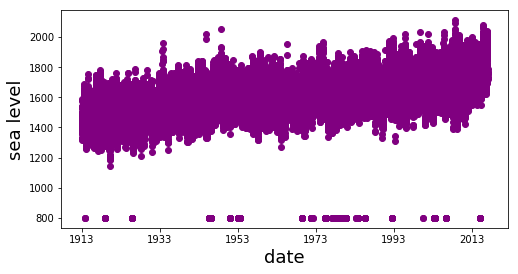

In [29]:
arrayOfTimes = [ (str(dfClean['Year'][i]) + ' ' +  str(dfClean['Month'][i]) + ' ' + str(dfClean['Day'][i])).split(' ') for i in range(len(dfClean['Day']))]
dateTimeList = [i for i in range(len(arrayOfTimes))]
for index, timeList in enumerate(iter(arrayOfTimes)):
    dateTimeList[index] = datetime.date(int(timeList[0]), int(timeList[1]), int(timeList[2])) #does anyone else like the way I coded this? :)
dateList = dates.date2num(dateTimeList)
fig, ax = plt.subplots(figsize=(8,4))
ax.xaxis_date()
ax.plot_date(dateList, np.array(dfClean['SL']), color='purple')
plt.xlabel('date', fontsize=18)
plt.ylabel('sea level', fontsize=18)
isXTickArray = [i for i in range(len(arrayOfTimes))] #boolean array for, for a given date, are we january 2nd or not...
for index, timeList in enumerate(iter(arrayOfTimes)):    
    if int(timeList[1]) == 1 and int(timeList[2]) == 2:
          isXTickArray[index] = 1
    else:
          isXTickArray[index] = 0


#plt.plot_date(locs, lables)
plt.show()



**Part C:** Use your cleaned sea levels data frame to create two new Pandas data frames or series:
1. one object to contain the sea levels between (and including) the years 1986 and 1995, and
2. another object to contain the sea levels between (and including) the years 2006 and 2015.

Then, create a single-panel figure that includes density histograms of each decade of sea levels. Be sure to label everything appropriately.

Finally, based on the data in front of you, formulate and state a hypothesis about how the mean sea level in the decade 2006-2015 compares to the mean sea level in the decade 1986-1995.

In [41]:
def inBounds(lo, hi, yearString):
    val = int(yearString)
    if val >= lo and val <= hi:
        return True
    else:
        return False

indexrange1 = []
for index, dataItem in enumerate(iter(dfClean.values)):
    if dataItem[0] >= 1986 and dataItem[0] <= 1995:
        indexrange1.append(index)
minVal1 = min(indexrange1)
maxVal1 = max(indexrange1) #find the min and max index of the dataframe we want to keep...

indexrange2 = []
for index, dataItem in enumerate(iter(dfClean.values)):
    if dataItem[0] >= 2006 and dataItem[0] <=2015:
        indexrange2.append(index)
minVal2 = min(indexrange2) #thanks built in min functions
maxVal2 = max(indexrange2)

#my name formate is df<last 2 digits of the min year adjoined with last 2 digits of the max year>    
df8695 = dfClean[['Year', 'Month', 'Day', 'SL']][minVal1:maxVal1 + 1] #array[start:end-1]
df0615 = dfClean[['Year', 'Month', 'Day', 'SL']][minVal2:maxVal2 + 1] #same process for other dataframe we want
print(df8695.head())
print(df0615.head())

       Year  Month  Day    SL
26644  1986      1    1  1608
26645  1986      1    2  1592
26646  1986      1    3  1600
26647  1986      1    4  1630
26648  1986      1    5  1585
       Year  Month  Day    SL
33949  2006      1    1  1561
33950  2006      1    2  1564
33951  2006      1    3  1556
33952  2006      1    4  1568
33953  2006      1    5  1602


**Part D:** Compute a 99.9% confidence interval for each of (1) the mean sea level in the 1986-1995 decade ($\mu_{1986-1995}$) and (2) the mean sea level in the 2006-2015 decade ($\mu_{2006-2015}$).  You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

Based on these two confidence intervals, do you think there is sufficient evidence to conclude that there is or is not a significant difference in the mean sea level between 1986-1995 and 2006-2015? Justify your answer. 

In [61]:


Za = stats.norm.ppf(1-(0.001/2))


meanValue1 = sum(df8695['SL'])/len(df8695['SL'])

upper = meanValue1 + (Za * np.std(df8695['SL'])/np.sqrt(len(df8695['SL'])))
lower = meanValue1 - (Za * np.std(df8695['SL'])/np.sqrt(len(df8695['SL'])))


meanValue2 = sum(df0615['SL'])/len(df0615['SL'])

upper2 = meanValue2 + (Za * np.std(df0615['SL'])/np.sqrt(len(df0615['SL'])))
lower2 = meanValue2 - (Za * np.std(df0615['SL'])/np.sqrt(len(df0615['SL'])))

for years $[1986, 1995]$ we are $99.9%$ conf the mean in sea levels is in range $[ 1653.0528008614085 1666.3957204967512 ]$
for years $[2006, 2015]$ we are $99.9%$ conf the mean in sea levels is in range $[ 1711.6095682654563 1726.0612970138427 ]$
Therefore, based on the data, 
 to say that we are $99.9%$ confident that the sea level has changed is non-controversal 
 because the upper bound of the CI for the first interval is $1666 $
 and the lower bound of the second interval is $1711$. 
 Therefore the sea level must have risen on average by:  $45$ 
 at least in these time ranges

**Part E:**  Compute a 99.9% confidence interval for the ***difference in mean sea level*** between the 2006-2015 and the 1986-1995 decades ($\mu_{2006-2015} - \mu_{1986-1995}$. Based on this, make a conclusion regarding your hypothesis from **Part C**, and compare to what your results in **Part D** implied. You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

For a confidence interval of the difference in mean sea level... 
the expected value is:

[sample mean 2] - [sample mean 1] = $\mu_2 - \mu_1 $

and then the standard deviation is $\sqrt{Var(X) + Var(Y)}$

==$\sigma$ =  $\sqrt{\frac{\sigma_1^2}{m} + \frac{\sigma_2^2}{n}}$ = 2.0364

the expected value $\mu_2 - \mu_1 $ expected value is  59.1112

so we can comptue the confidence interval as 59.1112 $+$ or $-$ $Z_{\frac{0.001}{2}} x 2.0364$


therefore the 99.9% CI for difference in mean sea levels is: $[ 52.410289454058905,$  $65.81205446708043 ]$ as verified by my python calculations below as well (below)





In [70]:
print("mu2-mu1", meanValue2-meanValue1)
expMu = meanValue2 - meanValue1
expSig = np.sqrt(( (np.std(df8695['SL'])**2)/len(df8695['SL']) )+( (np.std(df0615['SL']))/len(df0615['SL']) ))
print("stDev for CI: ", np.sqrt(( (np.std(df8695['SL'])**2)/len(df8695['SL']) )+( (np.std(df0615['SL']))/len(df0615['SL']) )))

lo = expMu - stats.norm.ppf(1-(0.001/2))*expSig
hi = expMu + stats.norm.ppf(1-(0.001/2))*expSig

print("99.9% conf the difference of mean sea levels in \n between periods [1986-1995] and [2006, 2015 is [", lo, hi, ']')



mu2-mu1 59.11117196056966
stDev for CI:  2.0364163713912693
99.9% conf the difference of mean sea levels in 
 between periods [1986-1995] and [2006, 2015 is [ 52.410289454058905 65.81205446708043 ]


**Part F:**  The confidence intervals from **Parts D** and **E** were derived using the Central Limit Theorem.  Which assumption of the Central Limit Theorem would likely be violated if we took more than one measurement per month to form our samples, and why?

if we take more than one measuremeant per month to form our samples,
then likely the distribution would not be that closeto as bell shaped as it actually is;
the distribution will look like the normal multiplied by some constant

---

<a id='p2'></a>
[Back to top](#top)

### [25 points] Problem 2 - Quality of Red vs White Wine 

**Part A:** Load the data in [`winequalityred.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm1ebc6q6ye) and [`winequalitywhite.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm17x9pu6y9) into Pandas DataFrames.  They are available under Resources on Piazza, and linked here and below.  A description of this dataset can be found on [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The quantity of interest for this problem is the quality of the wine.

Are we justified in using the Central Limit Theorem in our analysis of estimates of the mean and proportions of the data?  Justify your response. 

In [73]:
# read either local or web file version; pick whichever works for you
local_file_white = "data/winequality-white.csv"
local_file_red   = "data/winequality-red.csv"
web_file_white = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/winequality-white.csv"
web_file_red   = "https://raw.githubusercontent.com/dblarremore/csci3022/master/homework/homework5/data/winequality-red.csv"

dfRed   = pd.read_csv(local_file_red, delimiter=';')
dfWhite = pd.read_csv(local_file_white, delimiter=';')

dfWhite.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [78]:
print(len(dfWhite), 'and', len(dfRed), " is bigger than 30, by a factor of ", int(len(dfWhite))/30, ' and ', int(len(dfRed))/30,  "so the sample size should be big enough to apply the central limit theorem. ")


4898 and 1599  is bigger than 30, by a factor of  163.26666666666668  and  53.3 so the sample size should be big enough to apply the central limit theorem. 


**Part B:** Let $X$ be a random variable denoting the quality of a bottle of wine, and let $C$ be a random variable denoting its color (either red ($r$) or white ($w$)). For the remainder of this problem, we are concerned with probabilities such as "If I buy a random bottle of red wine, what is the probability that its quality is at least a 7?". We could write that probability as $P(X \geq 7 \mid C=r)$, for example, and consider it the ***proportion*** of the population of red wines that are at least a 7 in quality. Calculate and report estimates of $P(X \geq 7 \mid C=r)$ and $P(X \geq 7 \mid C=w)$.

Obtain 95% confidence intervals for the proportion of red and white wines that are **at least** a 7 in quality (obtain one CI for each color).  Based on your results, if you are interested in buying many high quality bottles of wine but are buying totally at random, is one color a better bet than the other? Fully justify your answer.

Calculations may be executed in Python, but you need to set up your work (*what* it is you are calculating) in Markdown/MathJax.

$P(X \ge 7 \mid C = r )$ = the proportion of red wines that are greater than 7 in quality.

so we can just sum up the number of red wines with quality greater than or equal to 7, 

and the number of red wines with quality less than 7 and then calulate $\frac{numGreater7}{TotalRedWines}$, this gets us our estimate of our proportion and also its expected value that it will take on, now we have to calculate $Z_a$ = $Z_{0.05/2}$ = 1.96

then we will calculate the 2 conf intervals:
# CI red:
 - for the first CI (red, quality > 7) we have:
 - estimate: 0.1357098
 - $Z_a$ = 1.96
 - sample std (red) = 0.34248
 - SO: Therefore the lower bound for our CI should be: $0.1357 - \frac{(1.96)(0.34248^2)}{1599}$ = 0.1355562
 - and the upper bound for our CI should be: $0.1357 + \frac{(1.96)(0.34248^2)}{1599}$ = 0.1358437
 - 95% CI for red proportion wines > 7 [0.1355562, 0.1358437]
 

# CI white:
- estimate: 0.2164
- $Z_a$ = 1.96
- sample std (white) = 0.4118
- Lower bound: $0.2164 - 1.96\frac{0.4118^2}{4898}$ = 0.2163
- Upper bound: $0.2164 + 1.96\frac{0.4418^2}{4898}$ = 0.2164
- 95% CI for white proportion wines > 7  [.2163, .2164]
 
 
 
 # Conclusion(s):
 - if I want to buy a lot of high quality bottles it would be better to buy random white bottles than random red bottles because the lower bound of the white CI is greater than the upper bound of the red CI. 

In [118]:
phat = [0 for i in range(len(dfRed['quality']))]
for index, dataItem in enumerate(iter(dfRed['quality'].values)):
    if dataItem >= 7:
        phat[index] = 1
print("estimate for P(X >= 7 | C = R): ", sum(phat)/len(phat)) #prop greater than 7 given red

phat2 = [0 for i in range(len(dfWhite['quality']))]
for index, datum in enumerate(iter(dfWhite['quality'].values)):
    if datum >= 7:
        phat2[index] = 1
print("estimage for P(X >= 7 | C = W): ", sum(phat2)/len(phat2)) #prop greater than 7 given whit
Za = stats.norm.ppf(1-(0.05/2))
#we will use the estimated proportions as the expected value of the proportion 
e = sum(phat)/len(phat)
lo = e - (Za*(np.std(phat)**2)/(len(phat)))
hi = e + (Za*(np.std(phat)**2)/(len(phat)))
print("stdev red: ", np.std(phat))
print("CI for proportion of red wine greater than 7 in quality: [", lo, hi, ']')
print("len phat: ", len(phat))
e2 = sum(phat2)/len(phat2)
lo2 = e2 - (Za*(np.std(phat2)**2)/(len(phat2)))
hi2 = e2 + (Za*(np.std(phat2)**2)/(len(phat2)))
print("stdev white: ", np.std(phat2))

print("CI for prop of white wine greater than 7 in quality: [", lo2, hi2, ']')
print("len phat2: ", len(phat2))


estimate for P(X >= 7 | C = R):  0.1357098186366479
estimage for P(X >= 7 | C = W):  0.21641486320947326
stdev red:  0.34248016550196897
CI for proportion of red wine greater than 7 in quality: [ 0.13556604790705143 0.1358535893662444 ]
len phat:  1599
stdev white:  0.41180027949419634
CI for prop of white wine greater than 7 in quality: [ 0.21634700497058132 0.2164827214483652 ]
len phat2:  4898


**Part C:** Now, as college students (and teachers), we might not be super concerned with buying a really high quality bottle of wine.  Let's focus instead on making sure we do *not* buy a really disgusting bottle of wine.  Calculate and report estimates of $P(X \geq 5 \mid C=r)$ and $P(X \geq 5 \mid C=w)$.

Obtain 95% confidence intervals for the proportion of red and white wines that are **at least** a 5 in quality, that is, $P(X \geq 5 \mid C)$.  Based on your results - and what you saw in Problem 1 - if you are interested in buying bottles of wine that are at least a 5 in quality, but are again buying wine totally randomly, can you conclude that you are better off buying one color over the other? Fully justify your answer.

In [126]:
phat3 = [0 for i in range(len(dfRed['quality']))]
for index, dataItem in enumerate(iter(dfRed['quality'].values)):
    if dataItem >= 5:
        phat3[index] = 1
print("estimate for P(X >= 5 | C = R): ", sum(phat3)/len(phat3))
prop1 = sum(phat3)/len(phat3)

phat4 = [0 for i in range(len(dfWhite['quality']))]
for index, datum in enumerate(iter(dfWhite['quality'].values)):
    if datum >= 5:
        phat4[index] = 1
print("estimage for P(X >= 5 | C = W): ", sum(phat4)/len(phat4))
prop2 = sum(phat4)/len(phat4)


lowerOne = prop1 - (1.96*(np.std(phat3))/len(phat3))
upperOne = prop1 + (1.96*(np.std(phat3))/len(phat3))


lowerTwo = prop2 - (1.96*(np.std(phat4))/len(phat4))
upperTwo = prop2 + (1.96*(np.std(phat4))/len(phat4))

print("95% CI for reds proportion of wines greater than 5 in quality : [", lowerOne, upperOne, ']')
print("95% CI for whites proportion of wines greater than 5 in quality : [", lowerTwo, upperTwo, ']')



estimate for P(X >= 5 | C = R):  0.9606003752345216
estimage for P(X >= 5 | C = W):  0.9626378113515721
95% CI for reds proportion of wines greater than 5 in quality : [ 0.9603619100254943 0.9608388404435488 ]
95% CI for whites proportion of wines greater than 5 in quality : [ 0.96256192129035 0.9627137014127942 ]


To calculate this CI (as I have done above with python)
we simply calculate the sample proportion, $\hat{p}$ for both red and white. 

then we calculate the standard deviation of both proportion arrays, (the standard deviation in proportion)
and we multiply that times the value $Z_a$ == $1.96$ then multiplied by $\frac{1}{n}$

**Part D:** Compute a 95% confidence interval for the difference in proportions of red and white wines that are at least a 5 in quality.

the difference of red wines >= 5 to num of white wines >=5 we get the value

$0.002038$ 

and what we want to obtain is a $95%$ CI for this value, that is,

are we $95%$ confident that we can reject the idea


that $p_1 - p_2$ is 0, that is, can we reject the idea that there is no difference in red and white on average for having proportion of quality greater than 5. 

$H_0:$ $p_2 - p_1$ == $0$, 

$H_1:$ $p_2 - p_1$  $\ne$ $0$


to calculate the $95%$ CI we calculate:

$\mu_1 - \mu_2$ $+-$ $1.96\sqrt{\frac{\sigma_1^2}{m} + \frac{\sigma_2^2}{n}}$

$\mu_1 - \mu_2$ = $0.00204$


$Z_a$ = $1.96$


$\sqrt{\frac{\sigma_1^2}{m} + \frac{\sigma_2^2}{n}}$ = $0.00557$


so we have: lower  =  $0.00204$ - $1.96(0.00557)$ = 0.01295
            upper = 0.00204$ + $1.96(0.00557)$ = -0.0088768
            
 so the $95%$ CI for difference in proportions is: $[-0.0088768, 0.01295]$ so we cannot reject the null hypothesis,
 at the 95 CI level we cannot conclude the proportion of red wines - white wines > 7 is not 0.
 
 the range of this CI is: $0.0185$

In [125]:
print("the diff in proportion I have is: ", -1*(0.960600 - 0.962638))
diff = -1*(0.960600 - 0.962638)
#note I use the sample standard deviation...
sigma = np.sqrt( ((np.std(phat3)**2)/len(phat3)) + ((np.std(phat4)**2)/len(phat4)) )
Zalpha = stats.norm.ppf(1-(0.05/2))
print("Z alpha: ", Zalpha)
lower = diff - (Zalpha*sigma)
upper = diff + (Zalpha*sigma)
print("Sigma: ", sigma)
print("lower: ", lower)
print("upper: ", upper)

print("sigma for stdev in red prop: ", np.std(phat3))
print("sigma for stdev in white prop: ", np.std(phat4))
print("sqrt(sigma1^2/m + sigma2^2/n) == ", np.sqrt( ((np.std(phat3)**2)/len(phat3)) + ((np.std(phat4)**2)/len(phat4)) ))

the diff in proportion I have is:  0.0020379999999999843
Z alpha:  1.959963984540054
Sigma:  0.005568877949036346
lower:  -0.008876800214410537
upper:  0.012952800214410505
sigma for stdev in red prop:  0.19454381083400707
sigma for stdev in white prop:  0.18964771421724863
sqrt(sigma1^2/m + sigma2^2/n) ==  0.005568877949036346


**Part E:**  Now, we have many more observations of white wines than red. This certainly contributes to the width of the 95% confidence interval for the proportion of red wines that are at least a 5 in quality, which you should have found in **Part C** to be wider than the corresponding confidence interval for white wines. 

How large would our sample size of red wines need to be in order to guarantee that this 95% confidence interval width is at most 0.01? Note that we are hypothetically adding more samples, so we do not know the precise value of $\hat{p}$.

In [132]:


#we are hypothetically adding more samples.... (bootstap?)
#we can at least keep our estimation of phat without bootstrapping. 
val = abs(lowerOne - upperOne)
o_size = len(dfRed['quality'])
while(val > 0.01):
    phat3 = [0 for i in range(len(dfRed['quality']))]
    for index, dataItem in enumerate(iter(dfRed['quality'].values)):
        if dataItem >= 5:
            phat3[index] = 1
    print("estimate for P(X >= 5 | C = R): ", sum(phat3)/len(phat3))
    prop1 = sum(phat3)/len(phat3)

    phat4 = [0 for i in range(len(dfWhite['quality']))]
    for index, datum in enumerate(iter(dfWhite['quality'].values)):
        if datum >= 5:
            phat4[index] = 1
    print("estimage for P(X >= 5 | C = W): ", sum(phat4)/len(phat4))
    prop2 = sum(phat4)/len(phat4)


    lowerOne = prop1 - (1.96*(np.std(phat3))/o_size)
    upperOne = prop1 + (1.96*(np.std(phat3))/o_size)
    print("95% CI for reds proportion of wines greater than 5 in quality : [", lowerOne, upperOne, ']')
    val = abs(lowerOne - upperOne)
    o_size += 1
    
print(lowerOne, upperOne, upperOne - lowerOne)



0.9603619100254943 0.9608388404435488 0.00047693041805452197


---

<a id='p3'></a>
[Back to top](#top)

### [30 points] Problem 3 - Exploring Confidence Intervals 

The [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) distribution is one of several distributions frequently used to model environmental extremes (for example, extreme temperatures and sea levels).  It is also fairly asymmetric, and thus interesting for investigating confidence intervals.  It is implemented in scipy.stats as [gumbel_r](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html), where the appendix "\_r" denotes the right-skewed version of the Gumbel distribution (as opposed to the left-skewed).

**Part A**: Complete the following code cell to plot a histogram of 100 realizations from the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  Be sure to leave this cell executed before turning in your assignment! Make your histogram grey with gold edges.

In [ ]:
mu = 8
beta = 2
n_sample = 100
# your code here

**Part B:** Look up the analytical mean and variance of the Gumbel distribution with parameters $\mu=8$ and $\beta=2$ and calculate them here by hand.  Note that the Euler–Mascheroni constant can be accessed via `np.euler_gamma`. 

Use the empirical mean from your sample in **Part A**, and the true variance of the Gumbel distribution to compute by hand a 95% confidence interval for the mean.

**Part C:  A theoretical interlude.** When Stella O'Flaherty (the famous octopus) ran her solution code for **Part B**, she obtained a 95% confidence interval of $[8.81, 9.82]$ for the mean of the $Gum(\mu=8, \beta=2)$ distribution. For each of the following, explain why or why not the situation described is correct, given the technical definition of a 95% confidence interval we went over in class.

**(i)** If you had no other evidence regarding true mean of the $Gum(\mu=8, \beta=2)$ distribution, you could say there is a 95% chance that its true mean falls between 8.81 and 9.82.

**(ii)** If a class of 100 students all construct 95% confidence intervals for the mean of the $Gum(\mu=8, \beta=2)$ distribution, then we expect about 95 of their CIs to contain the true mean, and about 5 of them to miss the true mean.

**(iii)** There is a 95% probability that any given random variable sampled from $Gum(\mu=8, \beta=2)$ will be between 8.81 and 9.82.

**Part D:** In this part you'll write a function to investigate the _coverage properties_ of a confidence interval for the mean of the Gumbel distribution. Complete the following function to randomly sample $m=500$ sample means with sample size $n=100$ for the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  For each random sample, compute the 66% confidence interval for the mean. Note that you actually know that the variance for the true population distribution is, $\sigma^2$.  Your function should do two things: 

1. Report the proportion of confidence intervals that successfully cover the true mean of the distribution 
2. Make a plot of 50 randomly selected confidence intervals. Overlay the intervals on the line $y=\textrm{True mean}$ (from **Part B**). Color confidence intervals black if they cover the true mean, and red if they don't.  

Be sure to leave this cell executed before turning in your assignment!

In [ ]:
def confidence_intervals(m=500, n=100):
    mu = 8
    beta = 2
    # Your code here
    proportion_CIs_covering_mean = 0
    print("proportion covering mean: {:.3f}".format(proportion_CIs_covering_mean))
    
    
confidence_intervals()

**Part E:** Does the proportion of confidence intervals that cover the true mean of the distribution agree with the theory described in class?  Justify your conclusion. 

---

<a id='p4'></a>
[Back to top](#top)

### [15 points] Problem 4 - Freethrows
***

Keep your skills sharp by answering these straightforward questions.

**Part A**: <font color='green'>You are driving through the paint toward the basket when Steph Curry fouls you. You step to the line to sink this freethrow shot, which is delivered in the form of a CSCI3022 problem:</font>

You have a shuffled deck of cards. It includes the usual 52 cards AND three special additional Octopus cards. You flip over the cards one by one, without replacing them in the deck. You count how many cards you'll have to flip until you flip over the second Octopus.  You repeat this many times. Simulate this process. Plot a histogram with binsize=1 of the outcomes, in lightgrey with white outline. Compute the mean, median, and mode for this dataset, indicate them on the plot too, using linstyles of green dashed, pink dotted, and black solid, respectively. Look up how to do a legend in MatPlotLib, and label your histogram, mean, median.
***

**Part B**: <font color='green'>You sink your first free throw and immediately get dap from your teammates, Oscar O'Flaherty and Octavia O'Flaherty. You prepare to take another shot, which—and you're not going to believe this—is another CSCI3022 problem:</font>

In general, which is wider: a 95% confidence interval or a 99% confidence interval? How would you explain this to your younger sibling, who is not a statistician?
***

**Part C**: <font color='green'>The crowd is silent. Everything is slow motion. You're literally in the air, releasing what looks to be a perfect shot to tie the match. As you release the ball, a hand appears to block it. It is Kevin Durant. :( 

Luckily, his fingertips also brush against your arm. That's a foul, and everyone saw it. Back to the line. Back to CSCI3022:</font>

Let $X$ be a normally-distributed random variable. You draw from it and get these values, stored in the numpy array **durant**, below. Compute a 95% confidence interval for the _standard deviation_.
***

In [ ]:
durant = np.array([3.7778,3.9459,3.8248,4.1111,4.0180,4.0898,4.0380,3.9273,3.9614,3.8387])

**Part D**: <font color='green'>"Draymond Green has it all, in spite of living in the Bay Area," you think to yourself. "But he doesn't have this shot..." You're all over him, and he's going to have to pass. You can see the irritation in his eyes. Then you realize that it's not irritation, and he's not being distracted by your superb defense. He's being distracted by this CSCI3022 problem:</font>

If you're doing quality control for the average strength of carbon fiber that will be used in airplane construction, and your alternative hypothesis is that the strength of the carbon is below tolerance, and therefore unsafe, would you rather have a low Type I error rate or a low Type II error rate? Explain.

***

**Part E**: <font color='green'>You are watching tape footage at halftime with your personal trainer, Stella O'Flaherty. You gotta focus up if you're going to match Klay Thompson's speed in the second half. You take a sip of Gatorade and Dr. O'Flaherty suggests that you do the following CSCI3022 problem:</font>

You measure 53 suckers from baby reef octopuses and find that they are, on average, 45.2 mm wide, with a standard devaition of 30.4mm. 

Then you measure 41 suckers from from baby dumbo octopuses and find that they are, on average, 52.8 mm wide, with a standard deviation of 22.8 mm. 

Is there statistical evidence at the 0.05 significance level that the true mean of baby dumbo octopus sucker width exceeds the true mean of baby reef octopus sucker width by more than 6 mm?  Use a test of your choice.

***